## Control dataset: Humadex NER dataset
https://huggingface.co/datasets/HUMADEX/english_ner_dataset

### Installing and importing all necessary libraries
https://huggingface.co/docs/hub/datasets-usage

In [ ]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install seqeval

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install hf_xet

     ---------------------------------------- 2.7/2.7 MB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install transformers[torch]

     ------------------------------------- 365.3/365.3 kB 23.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Downloading the dataset from HuggingFace
https://huggingface.co/docs/hub/datasets-usage

In [ ]:
from datasets import load_dataset
control_ds = load_dataset("HUMADEX/english_ner_dataset", split='train')
control_ds

c:\Users\chery\dl-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['sentence', 'tags'],
    num_rows: 445284
})

### Understanding the HUMADEX dataset

In [ ]:
#see first row
for sentence_tags in control_ds:
    print(sentence_tags)
    break

{'sentence': ['constipation', 'is', 'defined', 'based', 'on', 'each', 'individuals', 'normal', 'bowel', 'habits'], 'tags': [4, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
type(control_ds['sentence'])

datasets.arrow_dataset.Column

In [ ]:
type(control_ds['tags'])

datasets.arrow_dataset.Column

Tag encodings
- "O": 0
- "B-PROBLEM": 1
- "I-PROBLEM": 2
- "E-PROBLEM": 3
- "S-PROBLEM": 4 [symptoms]
- "B-TREATMENT": 5
- "I-TREATMENT": 6
- "E-TREATMENT": 7
- "S-TREATMENT": 8
- "B-TEST": 9
- "I-TEST": 10
- "E-TEST": 11
- "S-TEST": 12

The HUMADEX: a token-level BIES-style dataset for NER:
- 1 → B-PROBLEM (Begin)
- 2 → I-PROBLEM (Inside)
- 3 → E-PROBLEM (End)
- 4 → S-PROBLEM (Single-token span)

In [ ]:
#see sample size
print(f"There are {len(control_ds)} annotated samples.")

There are 445284 annotated samples.


In [ ]:
#count unique tags
unique_tags = set()
for tag in control_ds:
    unique_tags.update(tag['tags'])
print('Unique tags: ', unique_tags)

Unique tags:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [ ]:
label_map = {
    0: "O",
    1: "B-PROBLEM",
    2: "I-PROBLEM",
    3: "E-PROBLEM",
    4: "S-PROBLEM",
    5: "B-TREATMENT",
    6: "I-TREATMENT",
    7: "E-TREATMENT",
    8: "S-TREATMENT",
    9: "B-TEST",
    10: "I-TEST",
    11: "E-TEST",
    12: "S-TEST"
}


In [ ]:
#count frequence of each tagged token
from collections import Counter

tag_counter = Counter()
for tag in control_ds:
    tag_counter.update(tag['tags'])
print(tag_counter)

Counter({0: 3661382, 1: 419280, 3: 419280, 2: 369624, 5: 158334, 7: 158334, 4: 150942, 6: 124224, 8: 70431, 9: 50286, 11: 50286, 10: 33963, 12: 7473})


In [ ]:
total_tokens = sum(tag_counter.values())
print(f"Total tokens in dataset: {total_tokens}")

Total tokens in dataset: 5673839


In [ ]:
#extract symptom spans based on label map
def extract_spans(tags, label_map):
    spans = []
    i = 0
    while i < len(tags):
        label = label_map[tags[i]]
        
        if label == "O":
            i += 1
            continue
        
        elif label.startswith("S-"):
            entity_type = label[2:]
            spans.append((i, i, entity_type))
            i += 1
        
        elif label.startswith("B-"):
            entity_type = label[2:]
            start = i
            i += 1
            while i < len(tags) and label_map[tags[i]].startswith("I-"):
                i += 1
            if i < len(tags) and label_map[tags[i]].startswith("E-"):
                end = i
                spans.append((start, end, entity_type))
                i += 1
            else:
                # If E- tag is missing, treat B- as single token
                spans.append((start, start, entity_type))
        
        else:
            # Skip other tags, e.g., stray I- or E- without B-
            i += 1
            
    return spans


In [ ]:
spans = extract_spans([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label_map)
print("Format: (start_tag [0], end_tag[1], 'TAG LABEL[2]')" + '\n', spans)

Format: (start_tag [0], end_tag[1], 'TAG LABEL[2]')
 [(1, 3, 'PROBLEM'), (4, 4, 'PROBLEM'), (5, 7, 'TREATMENT'), (8, 8, 'TREATMENT'), (9, 11, 'TEST'), (12, 12, 'TEST')]


In [ ]:
#count number of symptom spans ('PROBLEM')
total_symptom_spans = 0

for tag in control_ds:
    spans = extract_spans(tag["tags"], label_map)
    symptom_spans = [span for span in spans if span[2] == "PROBLEM"] #(4, 4, 'PROBLEM')
    total_symptom_spans += len(symptom_spans)

print(f"Total symptom spans in dataset: {total_symptom_spans}")


Total symptom spans in dataset: 570222


In [ ]:
import random
example = random.choice(control_ds)
print("Tokens:", example['sentence'])
print("Tags:", example['tags'])

Tokens: ['try', 'applying', 'some', 'hand', 'lotion', 'to', 'see', 'if', 'it', 'helps']
Tags: [0, 0, 5, 6, 7, 0, 0, 0, 0, 0]


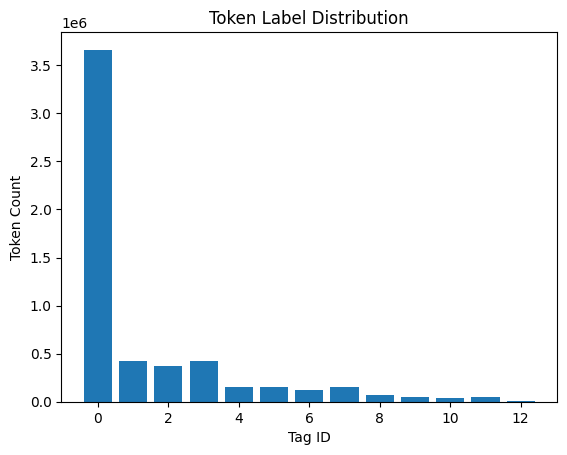

In [ ]:
import matplotlib.pyplot as plt

labels, counts = zip(*tag_counter.items())
plt.bar(labels, counts)
plt.xlabel("Tag ID")
plt.ylabel("Token Count")
plt.title("Token Label Distribution")
plt.show()

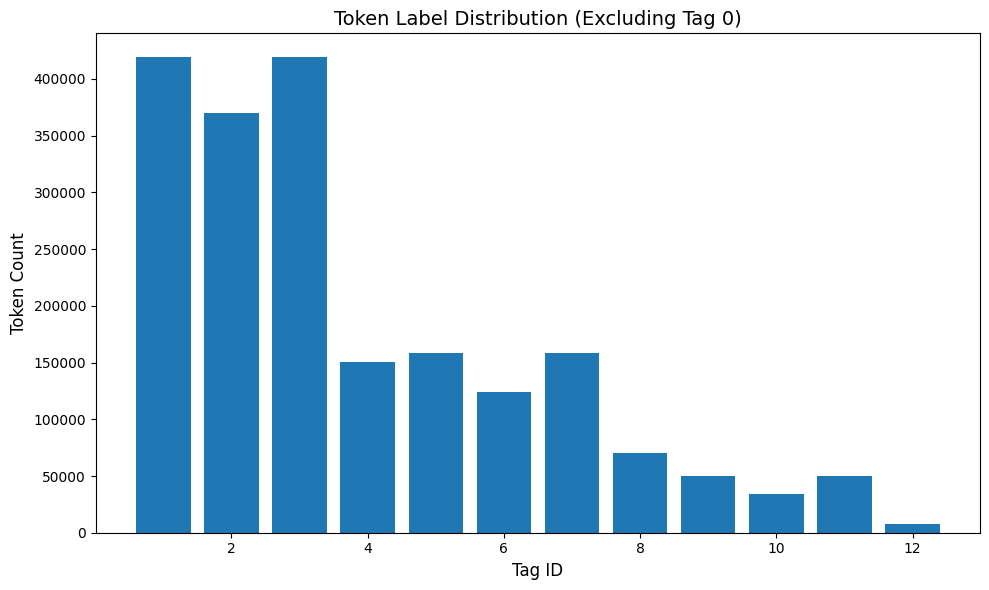

In [ ]:
#remove tag 0
if 0 in tag_counter:
    del tag_counter[0]

labels, counts = zip(*sorted(tag_counter.items()))  

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts)
plt.xlabel("Tag ID", fontsize=12)
plt.ylabel("Token Count", fontsize=12)
plt.title("Token Label Distribution (Excluding Tag 0)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from termcolor import colored

def visualize_spans(example, spans):
    tokens = example["sentence"]
    output = []
    for i, token in enumerate(tokens):
        in_span = False
        for span in spans:
            start, end, label = span
            if start <= i <= end:
                in_span = True
                break
        if in_span:
            output.append(colored(token, 'cyan', attrs=['bold']))
        else:
            output.append(token)
    print(" ".join(output))
    print("Spans:", spans)
    print()


example = random.choice(control_ds)
symptom_spans = extract_spans(example["tags"], label_map)
visualize_spans(example, symptom_spans)

an outpatient using in radiation is an beam external delivered setting energy usually of the
Spans: [(0, 0, 'TREATMENT')]



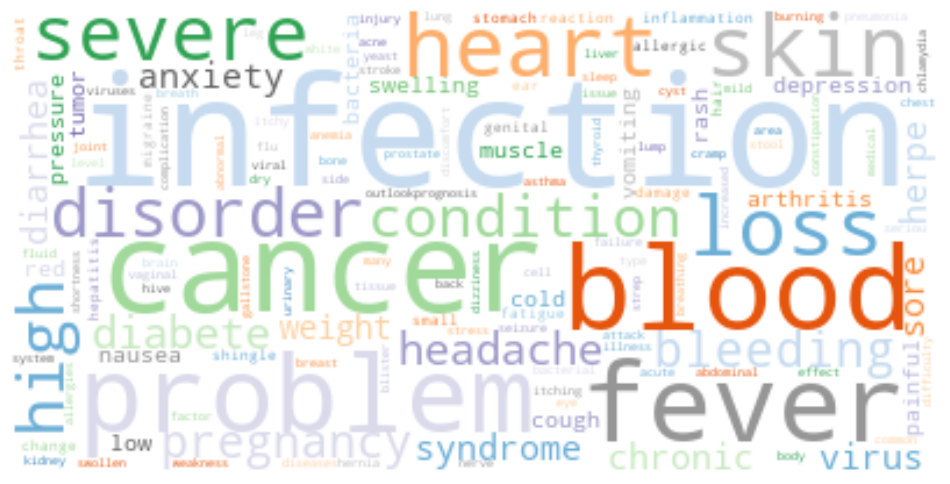

In [ ]:
#show wordcloud of all symptom spans (without bigrams)
from wordcloud import WordCloud, STOPWORDS

all_symptom_tokens = []

for sample in control_ds:  # or dataset
    spans = extract_spans(sample["tags"], label_map)
    tokens = sample["sentence"]
    for start, end, entity_type in spans:
        if entity_type == "PROBLEM":
            span_tokens = tokens[start:end+1]
            all_symptom_tokens.extend(span_tokens)

# Join all extracted symptom tokens into one big string
text = " ".join(all_symptom_tokens)

# Make a copy of the default stopwords
my_stopwords = STOPWORDS.copy()
my_stopwords.update(["pain", "symptom", 'symptoms','disease'])

# Make the word cloud
text_cloud_no_bigrams = WordCloud(
    stopwords = my_stopwords,
    colormap = 'tab20c',
    background_color = 'white',
    collocations = False  # For symptoms you probably want unique words, so turn off bigrams
).generate(text)

# Plot it
plt.figure(figsize = (12, 8))
plt.imshow(text_cloud_no_bigrams, interpolation = 'bilinear')
plt.axis('off')
plt.show()


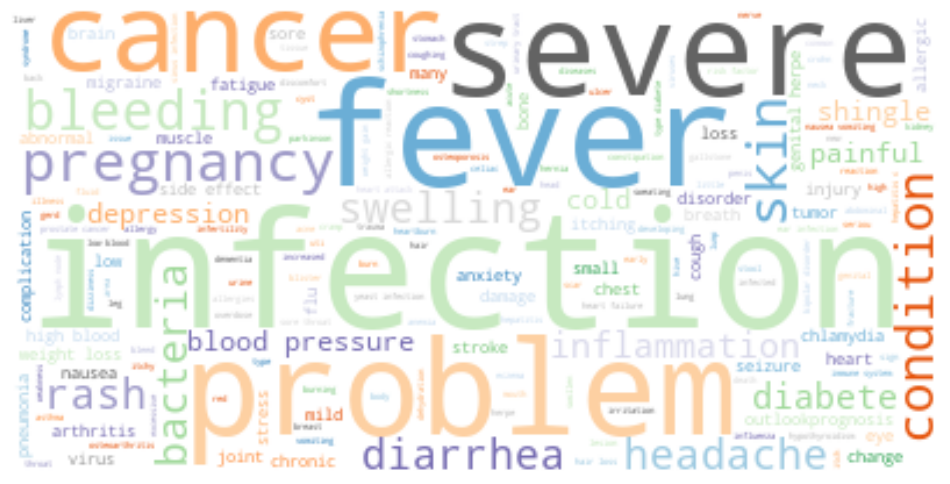

In [ ]:
# With bigrams
text_cloud_bigrams = WordCloud(
    stopwords = my_stopwords,
    colormap = 'tab20c',
    background_color = 'white',
    collocations = True  
).generate(text)

# Plot it
plt.figure(figsize = (12, 8))
plt.imshow(text_cloud_bigrams, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Split HUMADEX dataset to train, test, validate
why the need for both a test and validation set? (find source)

Test = “How will my model do in the real world?”

Validation = “How should I tweak my model during training?”

the DatasetDict module and the train_test_split() class
https://huggingface.co/docs/datasets/v4.0.0/en/package_reference/main_classes#datasets.DatasetDict

In [ ]:
label_map = {
    0: "O",
    1: "B-PROBLEM",
    2: "I-PROBLEM",
    3: "E-PROBLEM",
    4: "S-PROBLEM",
    5: "B-TREATMENT",
    6: "I-TREATMENT",
    7: "E-TREATMENT",
    8: "S-TREATMENT",
    9: "B-TEST",
    10: "I-TEST",
    11: "E-TEST",
    12: "S-TEST"
}

In [ ]:
control_ds.shape

(445284, 2)

In [ ]:
from datasets import DatasetDict

# split 80:20 train to test
test_split = control_ds.train_test_split(test_size=0.2, seed=42)

# split the 20% of train to 10% test 10% val
val_test = test_split['test'].train_test_split(test_size=0.5, seed=42)

# Wrap up
ds_splits = DatasetDict({
    'train': test_split['train'],
    'validation': val_test['train'],
    'test': val_test['test']
})


In [ ]:
ds_splits

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 356227
    })
    validation: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 44528
    })
    test: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 44529
    })
})

In [ ]:
#view your sets
print("Train set")
for i in range(3):
    print(ds_splits['train'][i])

print()

print("Test set")
for i in range(3):
    print(ds_splits['test'][i])

print()

print("Validation set")
for i in range(3):
    print(ds_splits['validation'][i])

Train set
{'sentence': ['is', 'having', 'chronic', 'diarrhea', 'after', 'appendix', 'removed', 'normal', 'it', 'has', 'been', 'removed', 'over', '3', 'weeks', 'ago', 'no', 'chronic', 'diarrhea', 'is', 'not', 'related', 'to', 'appendix', 'removal'], 'tags': [0, 0, 1, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 5, 7]}
{'sentence': ['her', 'in', 'pain'], 'tags': [1, 2, 3]}
{'sentence': ['mao', 'tranylcypromine', 'moclobemide', 'used', 'phenelzine', 'because', 'procarbazine', 'isocarboxazid', 'following', 'sibutramine', 'linezolid', 'product', 'be', 'methylene', 'inhibitors', 'occur', 'with', 'may', 'selegiline', 'rasagiline', 'should', 'this', 'medications', 'serious', 'rarely', 'the', 'blue', 'very', 'not', 'fatal', 'interactions'], 'tags': [5, 6, 8, 0, 5, 0, 6, 8, 6, 7, 8, 0, 0, 5, 7, 0, 0, 0, 5, 7, 0, 0, 7, 2, 2, 5, 7, 1, 0, 2, 3]}

Test set
{'sentence': ['symptoms', 'for', 'the', 'click', 'information', 'section', 'an', 'in', 'a', 'here', 'patient', 'example', 'of', 'p

## Install PyTorch with CUDA support

In [ ]:
#Installation process; run reset_pytorch.py
# Current specs: CUDA ver 12.5; not supported by PyTorch (requires downgrade to CUDA 12.1)

In [ ]:
#Download successful
#PyTorch version: 2.5.1+cu121
#Built with CUDA: 12.1
#CUDA available: True
#GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU

In [ ]:
#Check CUDA availbility and PyTorch installation
try:
    import torch

    print("✅ PyTorch is installed.")
    print("PyTorch version:", torch.__version__)
    print("Built with CUDA version:", torch.version.cuda)
    print("CUDA available:", torch.cuda.is_available())

    if torch.cuda.is_available():
        print("Detected GPU:", torch.cuda.get_device_name(0))
    else:
        print("❌ CUDA not available. PyTorch is running on CPU.")

except ImportError:
    print("❌ PyTorch is not installed in this environment.")


✅ PyTorch is installed.
PyTorch version: 2.5.1+cu121
Built with CUDA version: 12.1
CUDA available: True
Detected GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


### Testing HuggingFace GPU

In [ ]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from transformers import pipeline
qa = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", device=0)
qa(question="What is CUDA?", context="CUDA is a parallel computing platform and API from Nvidia.")


c:\Users\chery\dl-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\chery\dl-env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chery\.cache\huggingface\hub\models--distilbert-base-cased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, s

{'score': 0.29723653197288513,
 'start': 8,
 'end': 37,
 'answer': 'a parallel computing platform'}

In [ ]:
'''
1. Update Jupyter and ipywigets : done in bash; restart after installation
2. Activate Developer Mode to support symlinks: go to settings and activate Developer Mode. 
    This is used to save space when caching models or else it will just use more disk space
3. hf_xet package not installed: done in bash; restart after installation. 
    This is to get faster model downloads
'''


'\n1. Update Jupyter and ipywigets : done in bash; restart after installation\n2. Activate Developer Mode to support symlinks: go to settings and activate Developer Mode. \n    This is used to save space when caching models or else it will just use more disk space\n3. hf_xet package not installed: done in bash; restart after installation. \n    This is to get faster model downloads\n'

In [ ]:
# let's try again after all these fixes
from transformers import pipeline
qa = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", device=0)
qa(question="What is CUDA?", context="CUDA is a parallel computing platform and API from Nvidia.")


Device set to use cuda:0


{'score': 0.29723653197288513,
 'start': 8,
 'end': 37,
 'answer': 'a parallel computing platform'}

Interpreting the output:

'score': 0.29723653197288513, <- the confidence score assigned to this prediction (ranges 0-1; higher means more confidence)
'start': 8, <-character positions in the context string where the answer is found
'end': 37,
'answer': 'a parallel computing platform' <- the text snippet selected fromt he context; the model's best guess to the question